In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pathlib import Path
import os.path
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers,models
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_location = r'C:/Users/mohit/Computer Vision-Image Processing/Water Bottle Image Classification'
image_dir = Path(dataset_location)

filepaths = list(image_dir.glob(r'**/**/*.jpeg')) + list(image_dir.glob(r'**/**/*.jpg')) + list(image_dir.glob(r'**/**/*.png')) + list(image_dir.glob(r'**/**/*.PNG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
data = pd.concat([filepaths, labels], axis=1)

In [3]:
data.sample(10)

,Filepath,Label
462,C:\Users\mohit\Computer Vision-Image Processin...,Full Water level
218,C:\Users\mohit\Computer Vision-Image Processin...,Full Water level
125,C:\Users\mohit\Computer Vision-Image Processin...,Full Water level
160,C:\Users\mohit\Computer Vision-Image Processin...,Full Water level
122,C:\Users\mohit\Computer Vision-Image Processin...,Full Water level
530,C:\Users\mohit\Computer Vision-Image Processin...,Full Water level
68,C:\Users\mohit\Computer Vision-Image Processin...,Full Water level
494,C:\Users\mohit\Computer Vision-Image Processin...,Full Water level
41,C:\Users\mohit\Computer Vision-Image Processin...,Full Water level
57,C:\Users\mohit\Computer Vision-Image Processin...,Full Water level


In [4]:
data.Label.value_counts()

Full  Water level    361
Half water level     143
Overflowing           39
Name: Label, dtype: int64

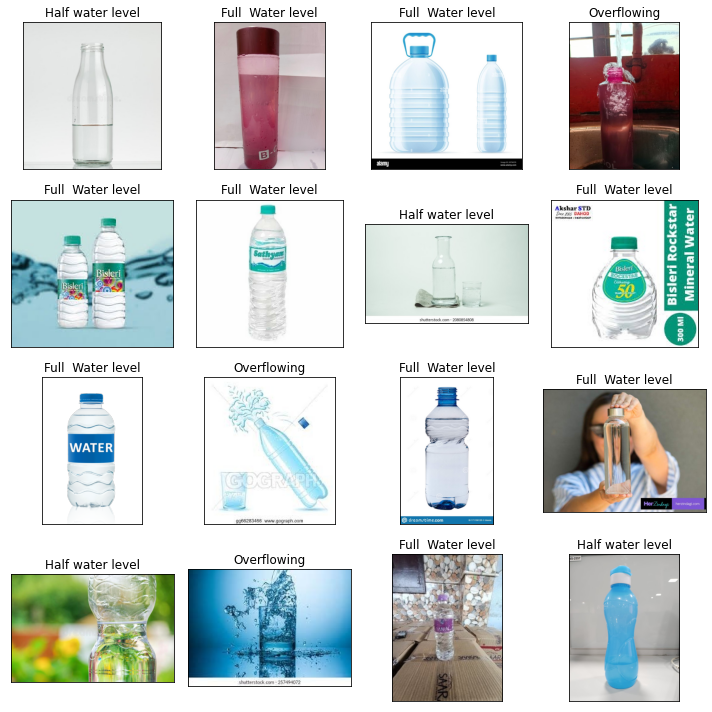

In [5]:
random_index = np.random.randint(0, len(data), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[random_index[i]]))
    ax.set_title(data.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/mohit/Computer Vision-Image Processing/Water Bottle Image Classification/Data",      
    shuffle=True,
    image_size= (256,256)
)

Found 486 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Full  Water level', 'Half water level', 'Overflowing']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)

[0 0 1 0 0 0 1 0 0 0 2 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0]


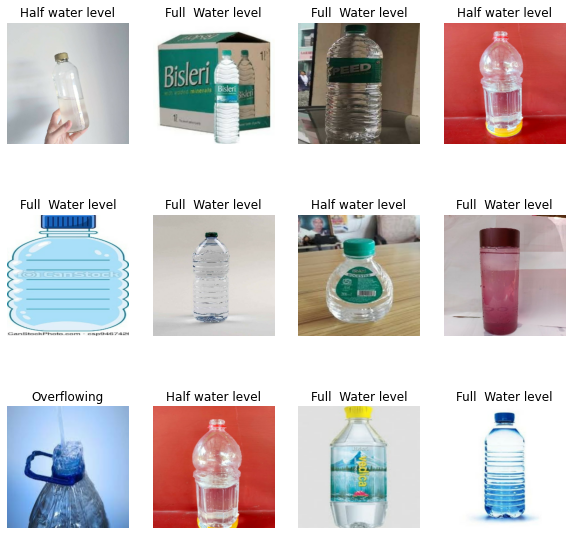

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [21]:
def train_test_validation(preprocessed_dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(preprocessed_dataset)
    
    if shuffle:
        ds = preprocessed_dataset.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = preprocessed_dataset.take(train_size)    
    val_ds = preprocessed_dataset.skip(train_size).take(val_size)
    test_ds = preprocessed_dataset.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [22]:
train, test, validation = train_test_validation(dataset)

In [23]:
len(train)

12

In [24]:
len(test)

3

In [25]:
len(validation)

1

# Model Building

**CNN Model**

In [26]:
#Resizing and Scaling
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [27]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [28]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model1 = models.Sequential([
    data_augmentation,
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# model1.build(input_shape=input_shape)

In [29]:
model1.summary()

Model: "sequential_2"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


sequential_1 (Sequential)    (None, 224, 224, 3)       0         

_________________________________________________________________

sequential (Sequential)      (None, 256, 256, 3)       0         

_________________________________________________________________

conv2d (Conv2D)              (None, 254, 254, 32)      896       

_________________________________________________________________

max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         

_________________________________________________________________

conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     

_________________________________________________________________

max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         

_________________________________________________________________

conv2d_2 (Conv2D)            (None, 60

In [30]:
model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [33]:
hist1 = model1.fit(train, batch_size=BATCH_SIZE, validation_data=validation, verbose=2, epochs=50)

Epoch 1/50

12/12 - 5s - loss: 0.7722 - accuracy: 0.6510 - val_loss: 0.9114 - val_accuracy: 0.5625

Epoch 2/50

12/12 - 5s - loss: 0.7243 - accuracy: 0.6615 - val_loss: 0.8399 - val_accuracy: 0.5938

Epoch 3/50

12/12 - 5s - loss: 0.7751 - accuracy: 0.6641 - val_loss: 0.7186 - val_accuracy: 0.6875

Epoch 4/50

12/12 - 5s - loss: 0.7285 - accuracy: 0.6615 - val_loss: 0.8679 - val_accuracy: 0.5625

Epoch 5/50

12/12 - 5s - loss: 0.6869 - accuracy: 0.7344 - val_loss: 0.8682 - val_accuracy: 0.6562

Epoch 6/50

12/12 - 5s - loss: 0.6736 - accuracy: 0.6927 - val_loss: 0.6543 - val_accuracy: 0.7812

Epoch 7/50

12/12 - 5s - loss: 0.7170 - accuracy: 0.6771 - val_loss: 0.7683 - val_accuracy: 0.6250

Epoch 8/50

12/12 - 5s - loss: 0.6908 - accuracy: 0.7083 - val_loss: 0.8194 - val_accuracy: 0.7188

Epoch 9/50

12/12 - 5s - loss: 0.6924 - accuracy: 0.7135 - val_loss: 0.8056 - val_accuracy: 0.6562

Epoch 10/50

12/12 - 5s - loss: 0.7004 - accuracy: 0.6849 - val_loss: 0.7271 - val_accuracy: 0.6562


In [34]:
acc = hist1.history['accuracy']
val_acc = hist1.history['val_accuracy']

loss = hist1.history['loss']
val_loss = hist1.history['val_loss']

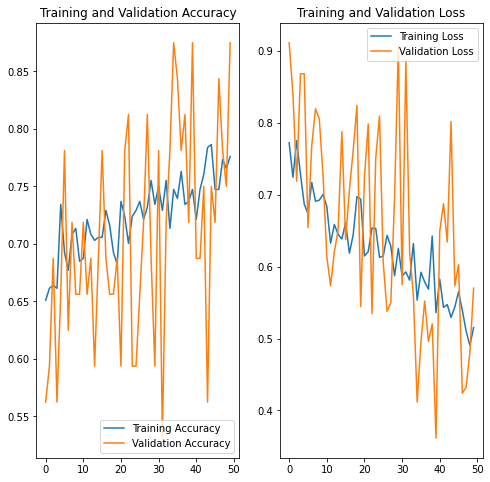

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
score1 = model1.evaluate(test)

3/3 [==============================] - 13s 5s/step - loss: 0.5735 - accuracy: 0.7857


first image to predict

actual label: Full  Water level

predicted label: Full  Water level


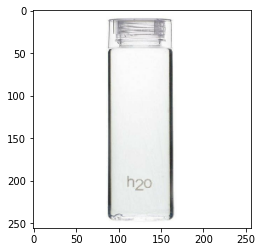

In [40]:
for images_batch, labels_batch in test.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model1.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
pred = model1.predict(test)
y_classes = [np.argmax(i) for i in pred]
y_classes[:10]

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1]